# Задание 3. Интегралы
Необходимо найти значение интеграла методом центральных прямоугольников. Используем три версии алгоритма:
- Однопоточный алгоритм
- Распараллеливание по данным: 
  - С обеспечением синхронизации за счет критической секции
  - С использованием редукции оператором `+`

## Описание подходов
Все описанные алгоритмы находятся в модуле [`integrals`](../../integrals/integrals.c).

### Однопоточная версия
Реализация данного подхода содержится в методе `integrateInSingleThread`. 

```c
static double integrateInSingleThread(double (*function)(double x), double leftBorder, double rightBorder, int numRects)
{
    double result = 0;
    double h = (rightBorder - leftBorder) / numRects;
    for (int i = 0; i < numRects; i++)
    {
        result += function(leftBorder + h / 2 + i * h);
    }
    result *= h;
    return result;
}
```

### Синхронизация за счет критической секции
В данном подходе для обеспечения синхронизации потоков используется критическая секция.

```c
static double integrateWithCriticalSection(double (*function)(double x), double leftBorder, double rightBorder, int numRects)
{
    double result = 0;
    double partialSum = 0;
    double h = (rightBorder - leftBorder) / numRects;

#pragma omp parallel shared(leftBorder, rightBorder, numRects, result, h, function) private(partialSum) default(none)
    {

        int threadNum = omp_get_thread_num();
        double rectsPerThread = numRects / omp_get_num_threads();
        if (threadNum == omp_get_num_threads() - 1)
        {
            rectsPerThread += numRects % omp_get_num_threads();
        }

        double threadLeftBorder = leftBorder + threadNum * h;

        for (int i = 0; i < rectsPerThread; i++)
        {
            partialSum += function(threadLeftBorder + h / 2 + i * h);
        }
#pragma omp critical
        {
            result += partialSum;
        }
    }
    return result * h;
}
```

### Редукция
В данном подходе использована редукция с оператором `+`. 
```c
static double integrateWithReduction(double (*function)(double x), double leftBorder, double rightBorder, int numRects)
{

    double result = 0;
    double h = (rightBorder - leftBorder) / numRects;
    int i = 0;
#pragma omp parallel for shared(leftBorder, h, numRects) private(i) reduction(+ \
                                                                              : result)
    for (i = 0; i < numRects; i++)
    {
        result += function(leftBorder + h / 2 + i * h);
    }

    return result * h;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы для интегрирования функции y=exp(x) на отрезке от 0 до 1 с разбиением отрезка на 100, 10 000 и 1 000 000 частей.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
dataset = dataset.astype({'method': 'category',  'num_rects': 'category'})
print(dataset.head(10))


   num_threads            method num_rects  elapsed_time
0            1            single       100        0.0059
1            2  critical_section       100        0.0488
2            2         reduction       100        0.0011
3            3  critical_section       100        0.0330
4            3         reduction       100        0.0012
5            4  critical_section       100        0.0421
6            4         reduction       100        0.0011
7            5  critical_section       100        0.0401
8            5         reduction       100        0.0013
9            6  critical_section       100        0.0437


Рассчитаем среднее время работы каждого из описанных подходов для каждого из методов

In [2]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['num_rects', 'elapsed_time']].groupby('num_rects').agg({'elapsed_time': 'mean'}).sort_values('num_rects')
means_for_critical_section = dataset[dataset['method'] == 'critical_section'][['num_rects', 'elapsed_time']].groupby('num_rects').agg({'elapsed_time': 'mean'}).sort_values('num_rects')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['num_rects', 'elapsed_time']].groupby('num_rects').agg({'elapsed_time': 'mean'}).sort_values('num_rects')

In [3]:
num_rects = dataset.num_rects.unique().tolist()

In [4]:
def visualize(ylabel, title, data):
    labels = num_rects
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['single'],
                    width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['critical_section'],
                    width, label='Многопоточная с критической секцией')
    rects3 = ax.bar(x + width/2, data['reduction'],
                    width, label='Многопоточная с редукцией')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Функция')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из размеров разбиений. 

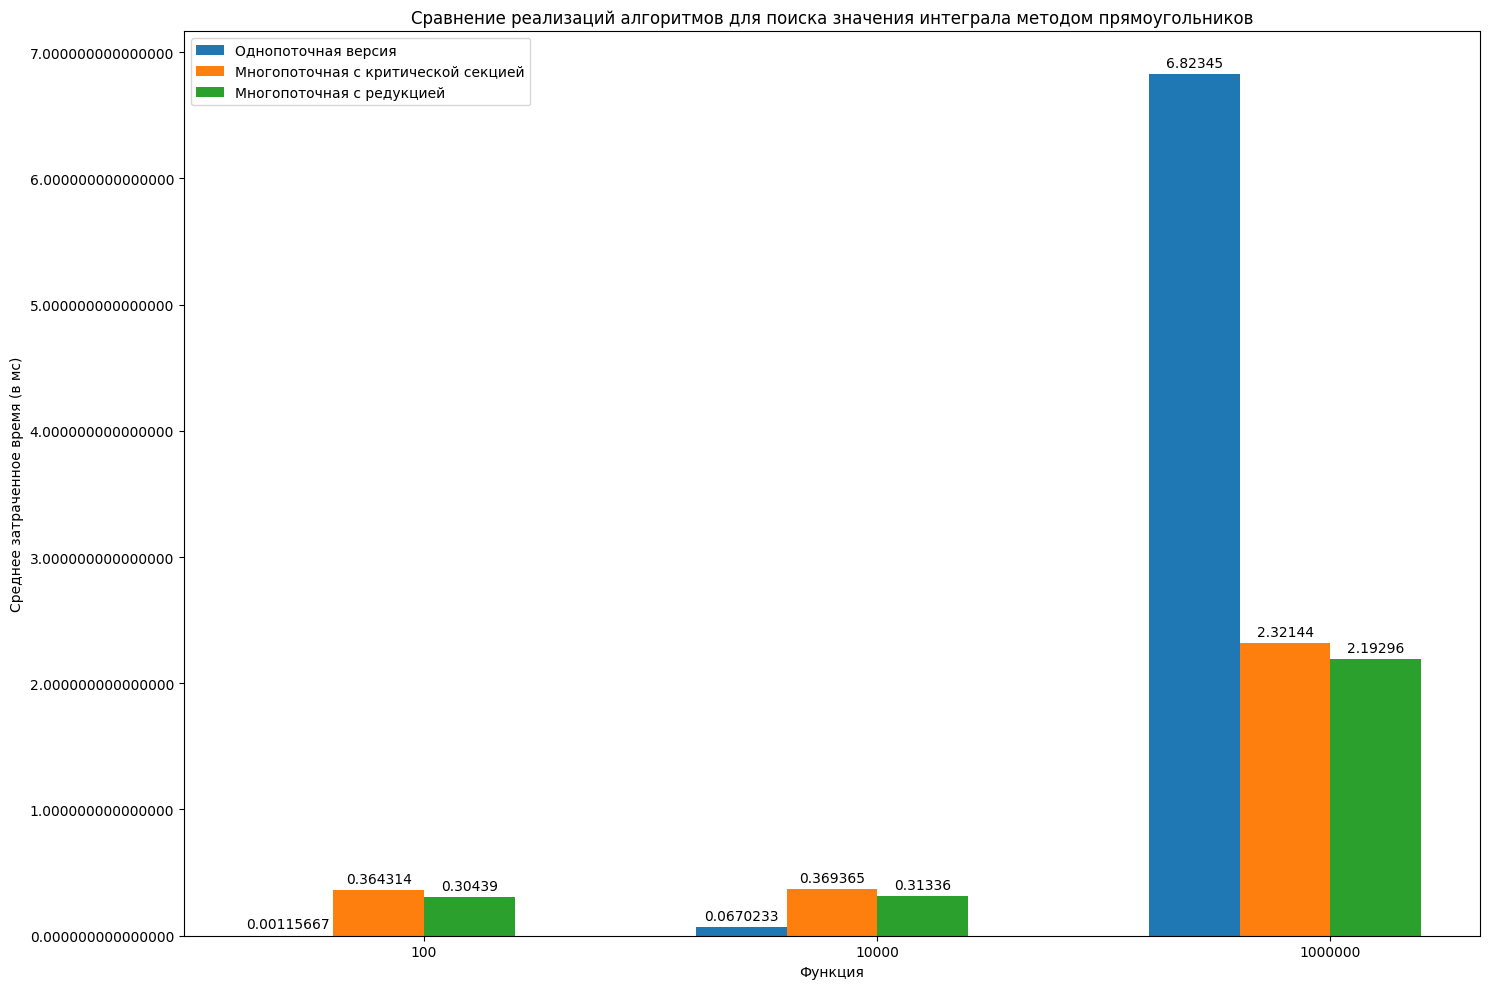

In [5]:
mean_data = dict(zip(dataset['method'].unique(), [
    means_for_single_thread['elapsed_time'], means_for_critical_section['elapsed_time'],  means_for_reduction['elapsed_time']]))
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для поиска значения интеграла методом прямоугольников', mean_data)


Легко заметить, что применение многопоточности оправдано лишь для разбиений отрезка на 1 000 000 частей. Для него все 3 метода в среднем работают примерно в 4 раза быстрее, чем однопоточная программа. Далее рассмотрим зависимость ускорения от числа потоков для каждого из имеющихся размеров разбиений.

In [6]:
means_for_single_thread = dataset[dataset['method'] == 'single'].groupby(
    'num_rects').agg({'elapsed_time': 'mean'}).reset_index()

means_for_multhread = dataset[dataset['num_threads'] >= 2].groupby(
    ['num_threads', 'num_rects', 'method']).agg({'elapsed_time': 'mean'})
means_for_multhread = means_for_multhread[means_for_multhread['elapsed_time'].notnull(
)].reset_index()


smtet = means_for_multhread[means_for_multhread['num_rects']
                            == num_rects[0]]['elapsed_time']
sstet = means_for_single_thread[means_for_single_thread['num_rects']
                                == num_rects[0]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_rects']
                        == num_rects[0], 'boost'] = sstet.loc[0]/ smtet 

mmtet = means_for_multhread[means_for_multhread['num_rects']
                            == num_rects[1]]['elapsed_time']
mstet = means_for_single_thread[means_for_single_thread['num_rects']
                                == num_rects[1]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_rects']
                        == num_rects[1], 'boost'] = mstet.loc[1] / mmtet 

lmtet = means_for_multhread[means_for_multhread['num_rects']
                            == num_rects[2]]['elapsed_time']
lstet = means_for_single_thread[means_for_single_thread['num_rects']
                                == num_rects[2]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_rects']
                        == num_rects[2], 'boost'] = lstet.loc[2] / lmtet 

In [7]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_critical = plt.plot(
        x, data.loc[filters['critical'], 'boost'], label='Критическая секция')
    bfsa_reduction = plt.plot(
        x, data.loc[filters['reduction'], 'boost'], label='Редукция')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()
        

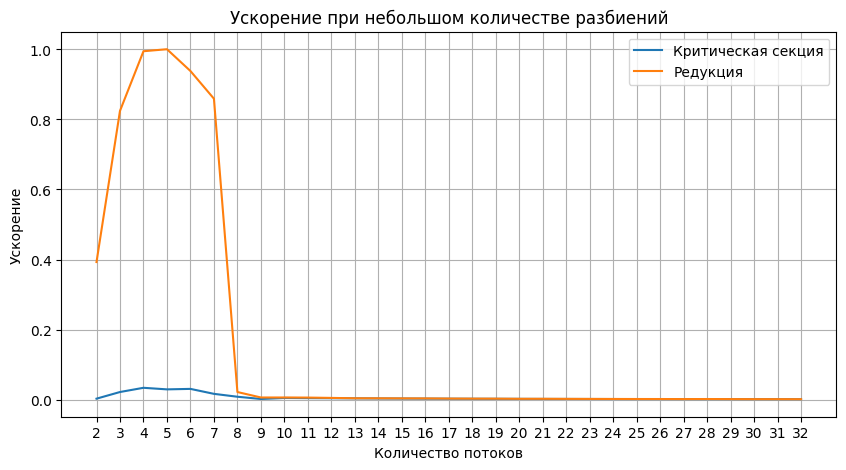

In [8]:
filters_for_small_num_rects = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['num_rects'] == num_rects[0]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_rects'] == num_rects[0]),
}
visualize_boost(means_for_multhread, filters_for_small_num_rects,
                'Ускорение при небольшом количестве разбиений')


Как и ожидалось, при небольшом количестве разбиений оба алгоритма оказываются менее эффективными, чем однопоточная версия

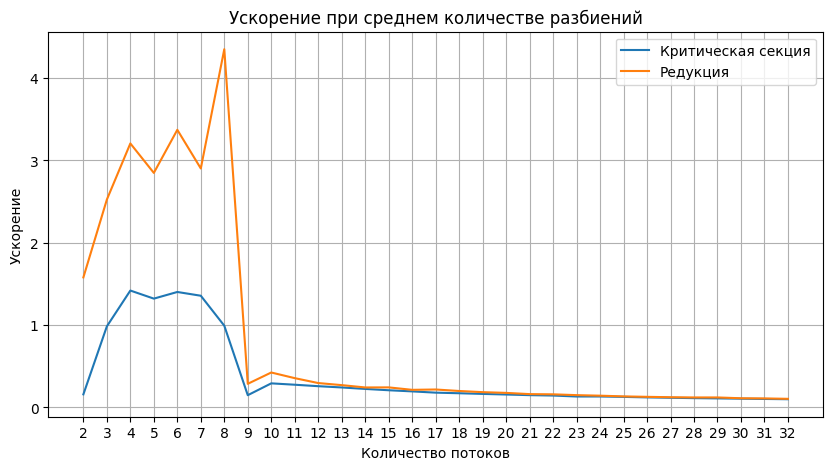

In [9]:
filters_for_medium_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['num_rects'] == num_rects[1]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_rects'] == num_rects[1])
}
visualize_boost(means_for_multhread, filters_for_medium_arrays,
                'Ускорение при среднем количестве разбиений')


Для среднего количества разбиений максимальное ускорение составило примерно 4.5 раза для редукции при использовании 8 потоков. Стоит заметить, что даже при двух потоках редукция оказывается быстрее однопоточной версии. Алгоритм с критической секцией оказывается незначительно быстрее однопоточной версии при использовании 3-8 потоков. 

При увеличении количества потоков до 9 ускорение резко снижается и при дальнейшем росте количества потоков стремится к 0.

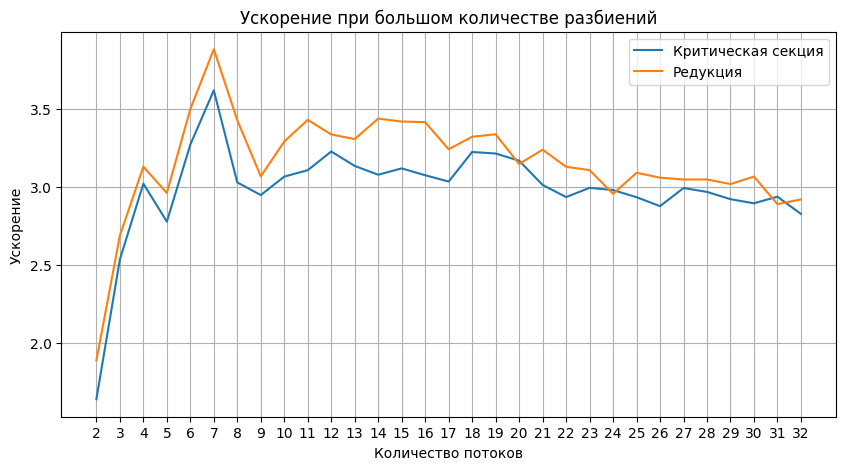

In [10]:
filters_for_large_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['num_rects'] == num_rects[2]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_rects'] == num_rects[2]),
}
visualize_boost(means_for_multhread, filters_for_large_arrays,
                'Ускорение при большом количестве разбиений')


На большом количестве разбиений эффективность алгоритмов меньше по сравнению со средним количеством разбиений. Однако оба алгоритма показывают максимальное ускорение более чем в 3.5 раза при использовании 7 потоков. Более того, при любом количестве потоков оба алгоритма работают быстрее однопоточной версии. 